In [1]:
import scanpy as sc
import scvi
import scarches as sca
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Normal, Poisson
import torch.nn.functional as F
# from dalib.modules import domain_discriminator
# from scvi.nn._base_components import DecoderSCVI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Global seed set to 0
 captum (see https://github.com/pytorch/captum).


device(type='cuda')

In [2]:
ref_latent = sc.read_h5ad("./reference_latent.h5ad")
query_adata = sc.read_h5ad("/home/wyh/liver_atlas/data/Aizarani2019/Aizarani2019_plot_V2.h5ad")
ref_path = "./scvi_ref_model/"


In [3]:
from scipy.sparse import csr_matrix
def feature_alignment(test_set, gene_list):
    test_set.X = test_set.layers['counts']
    
    # set test_set features as gene_list, zero-filling for missing features
    selected_set = set(gene_list)
    test_set_genes = set(test_set.var_names)
    common_set = selected_set & test_set_genes
    gene_extra = selected_set - common_set
    n_extra = len(gene_extra)
    if n_extra / len(gene_list) > 0.05:
        print("Warning: %d features not exist in testset." % len(gene_extra))

    if n_extra > 0:  # fill zeros for missing features
        new_mtx = csr_matrix(test_set.X, shape=(test_set.n_obs, test_set.n_vars + n_extra))
        test_adata = sc.AnnData(new_mtx)
        test_adata.obs = test_set.obs
        test_adata.layers['counts'] = test_adata.X
        test_adata.obs_names = test_set.obs_names
        test_adata.var_names = list(test_set.var_names) + list(gene_extra)
        # test_adata.obs = test_set.obs
        return test_adata[:, gene_list]
    else:
        return test_set[:, gene_list]
    
gene_selected = pd.read_csv(ref_path + "var_names.csv", header=None)[0].tolist()
query_adata = feature_alignment(query_adata, gene_selected)

scvi_model = sca.models.SCVI.load_query_data(
    query_adata,
    ref_path,
    freeze_dropout = True,
)

scvi_model.train(max_epochs=0, plan_kwargs=dict(weight_decay=0.0))
# scvi.data.view_anndata_setup(scvi_model.adata)

/tmp/ipykernel_1893043/2004310203.py:16: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  test_adata = sc.AnnData(new_mtx)


INFO     Using data from adata.layers["counts"]                                              


/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_archesmixin.py:95: UserWarning: Query integration should be performed using models trained with version >= 0.8
  warnings.warn(
/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)
/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
INFO:scvi.data._anndata:Using data from adata.layers["counts"]


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    


INFO:scvi.data._anndata:Registered keys:['X', 'batch_indices', 'labels']


INFO     Successfully registered anndata object containing 10372 cells, 2000 vars, 4 batches,
         9 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


INFO:scvi.data._anndata:Successfully registered anndata object containing 10372 cells, 2000 vars, 4 batches, 9 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.
/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Training: 0it [00:00, ?it/s]

In [43]:
class TransferMappingModule(nn.Module):
    def __init__(
        self, 
        n_latent=10, 
        n_gene=2000, 
        n_hidden=[64, 128],
        dropout_rate=0.1,
        extra_decoder_kwargs=None
    ):
        
        
        super(TransferMappingModule, self).__init__()
        
#         # decoder (froze param)
#         self.decoder = Decoder(
#             n_latent=n_latent, 
#             n_out=n_gene, 
#         )

        # transfer
        self.fc11 = nn.Linear(n_latent, n_hidden[0])
#         self.fc12 = nn.Linear(n_hidden[0], n_hidden[1])
        self.fc2 = nn.Linear(n_hidden[0], n_latent)
        self.dropout = nn.Dropout(p=dropout_rate)
        
    def query_transfer(self, z):
        h = F.relu(self.fc11(z))
        h = self.dropout(h)
#         h = F.relu(self.fc12(h))
#         h = self.dropout(h)
        return self.fc2(h)
    
#     def generative(self, z):
#         categorical_input = ()
#         size_factor = None
# #         px_scale, px_r, px_rate, px_dropout = self.decoder(
# #                 self.dispersion,
# #                 self.query_transfer(z),
# #                 size_factor,
# #                 *categorical_input,
# #                 y,
# #             )
# #         px = NegativeBinomial(mu=px_rate, theta=px_r, scale=px_scale)
#         px_scale, px_dropout = self.decoder(z)
#         poisson = Poisson(torch.exp(library) * px_scale + self.eps)
#         decoder_poisson = Poisson(px_scale + self.eps)
#         return px
    
    def forward(self, z):
        return self.query_transfer(z)

# 定义discriminator类
class DomainDiscriminator(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=128, dropout_rate=0.1):
        super(DomainDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_rate=0.1):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [44]:
from torch.utils.data import Dataset, DataLoader

# 自定义dataset类
class MyDataset(Dataset):
    def __init__(self, adata, X_key):
        self.data = adata
        if X_key == "X":
            self.X = adata.X
        else:
            self.X = adata.layers[X_key]
        
    def __len__(self):
        return self.data.n_obs
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx,:].toarray())
    

In [45]:
def discriminator_loss(discriminator, ref_latent, query_latent, mode):
    if mode == "trainD":
        ref_labels = torch.zeros(ref_latent.shape[0], 1)
        query_labels = torch.ones(query_latent.shape[0], 1)
        labels = torch.cat((ref_labels, query_labels), dim=0).to(device)
        
    elif mode == "trainM":
        labels = torch.zeros(ref_latent.shape[0] + query_latent.shape[0], 1).to(device)
    else:
        print("No such mode for discriminator loss.")

    # 将源领域和目标领域数据合并并输入到域鉴别器中
    data = torch.cat((ref_latent, query_latent), dim=0).to(device)
    predictions = discriminator(data)

    # 计算域鉴别器的损失
    criterion = nn.BCELoss()
    loss = criterion(predictions, labels)
    return loss #* 1e3

def reconstruction_loss(scvi_model, transfer_mapping_module, X):
    batch_id = 3
    n_sample = X.shape[0]
    batch_index = torch.full((n_sample, 1), batch_id)
    inference_output = scvi_model.module.inference(
        X, 
        batch_index=batch_index
    )
    z = inference_output['z']
    transferred_z = transfer_mapping_module(z)
    generative_output = scvi_model.module.generative(
        z=transferred_z,
        library=inference_output['library'], 
        batch_index=batch_index
    )    
    reconst_loss = scvi_model.module.get_reconstruction_loss(
        X, 
        generative_output['px_rate'], 
        generative_output['px_r'], 
        generative_output['px_dropout']
    )
#     loss = -generative_x.log_prob(x).sum(-1)
    return torch.mean(reconst_loss)


In [46]:
import scanpy as sc
dataset = MyDataset(query_adata, "counts")

# hyper-parameters
learning_rate = 0.1
batch_size = 128
num_workers = 4
shuffle = True
num_epoch = 150

# Instantiate trainloader
train_loader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        num_workers=num_workers, 
                        shuffle=shuffle)
# Instantiate mapping module
mapping_module = TransferMappingModule(n_latent=30, n_gene=2000,  
                                       dropout_rate=0.1).to(device)
# Instantiate discriminator
discriminator = DomainDiscriminator(input_dim=30, hidden_dim=128, 
                                    dropout_rate=0.1).to(device)

# criterion = nn.BCELoss()
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizerM = optim.Adam(mapping_module.parameters(), lr=learning_rate)

from torch.optim.lr_scheduler import StepLR
schedulerD = StepLR(optimizerD, step_size=20, gamma=0.5)
schedulerM = StepLR(optimizerM, step_size=20, gamma=0.5)

In [48]:
reconst_loss_rate = 0.01
num_batches = len(train_loader)

mapping_module.train()
discriminator.train()

z_record = {}
for epoch in range(20):
    # ref_latent to GPU
    ref_latent_subset = sc.pp.subsample(ref_latent, n_obs = 10000, 
                                        random_state = epoch, copy=True)
    ref_latent_tensor = torch.tensor(ref_latent_subset.X).to(device)
    
    for i, x in enumerate(train_loader):
        query_x = x.to(device)
        # encode and transfer
        batch_id = 3
        n_sample = query_x.shape[0]
        batch_index = torch.full((n_sample, 1), batch_id)
        inference_output = scvi_model.module.inference(
            query_x, 
            batch_index=batch_index
        )
        query_latent = torch.squeeze(inference_output['z'])
        query_latent_transferred = mapping_module(query_latent)
        
        ##############################
        #   Training discriminator   #
        ##############################
        # forward
        lossD = discriminator_loss(
            discriminator, 
            ref_latent_tensor, 
            query_latent_transferred,
            "trainD"
        )
        # backward
        optimizerD.zero_grad()
        lossD.backward()
#         lossD.backward(retain_graph=True)
        optimizerD.step()         
        
        ##########################
        #   Training generator   #
        ##########################
#         inference_output = scvi_model.module.inference(
#             query_x, 
#             batch_index=batch_index
#         )
#         query_latent = torch.squeeze(inference_output['z'])
#         query_latent_transferred = mapping_module(query_latent)
        
        # forward
#         discrim_loss = discriminator_loss(
#             discriminator, 
#             ref_latent_tensor, 
#             query_latent_transferred,
#             "trainM"
#         )
        reconst_loss = reconstruction_loss(scvi_model, mapping_module, 
                                           torch.squeeze(query_x))
        lossM = reconst_loss_rate * reconst_loss# + discrim_loss
        
        # backward
        optimizerM.zero_grad()
        lossM.backward()
        optimizerM.step()
        
        if i == 0:
            z_mean = torch.tensor(scvi_model.get_latent_representation()).to(device)
            z_mean_transferred = mapping_module(z_mean)
            z_record[epoch] = z_mean_transferred
#             break     

        if i%40 == 0:
            print(lossD.item())
#             print('Epoch [{}/{}], step [{}/{}], D_loss: {:.4f}, M_loss: {:.4f}, M_d_loss: {:.4f}, M_r_loss: {:.4f}'.format(
#                 epoch+1, num_epoch, i+1, num_batches, 
#                 lossD.item(), lossM.item(), 
#                 discrim_loss.item(), reconst_loss.item()))
    schedulerD.step()
    schedulerM.step()



0.00021126690262462944
1.2638230323791504
1.2638230323791504
1.263823390007019


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c19ef70>
Traceback (most recent call last):
  File "/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/selectors.py", line 416,

KeyboardInterrupt: 

In [37]:
save_path = './saves'
ad = sc.AnnData(z_record[0].detach().cpu().numpy())
ad.obs["cell_type"] = query_adata.obs["level1"].tolist()
ad.obs["batch"] = query_adata.obs["batch"].tolist()
ad.raw = ad
ad.write(save_path + "/ad_epoch00_new.h5ad")
# sc.pp.neighbors(ad, n_neighbors=4)
# sc.tl.umap(ad)
# sc.pl.umap(ad)

In [38]:
ad = sc.AnnData(z_record[19].detach().cpu().numpy())
ad.obs["cell_type"] = query_adata.obs["level1"].tolist()
ad.obs["batch"] = query_adata.obs["batch"].tolist()
ad.raw = ad
ad.write(save_path + "/ad_epoch19_new.h5ad")

In [88]:
lossD = discriminator_loss(
            discriminator, 
            ref_latent_tensor, 
            torch.squeeze(query_latent_transferred),
            "trainD"
        )
lossD

tensor(0.005, device='cuda:0', grad_fn=<MulBackward0>)

In [11]:
discriminator_loss(discriminator, 
                   ref_latent_tensor, 
                   z_record[0], 
                   mode="trainM")

tensor(0.034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [12]:
discriminator_loss(discriminator, 
                   ref_latent_tensor, 
                   z_record[19], 
                   mode="trainM")

tensor(34.004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

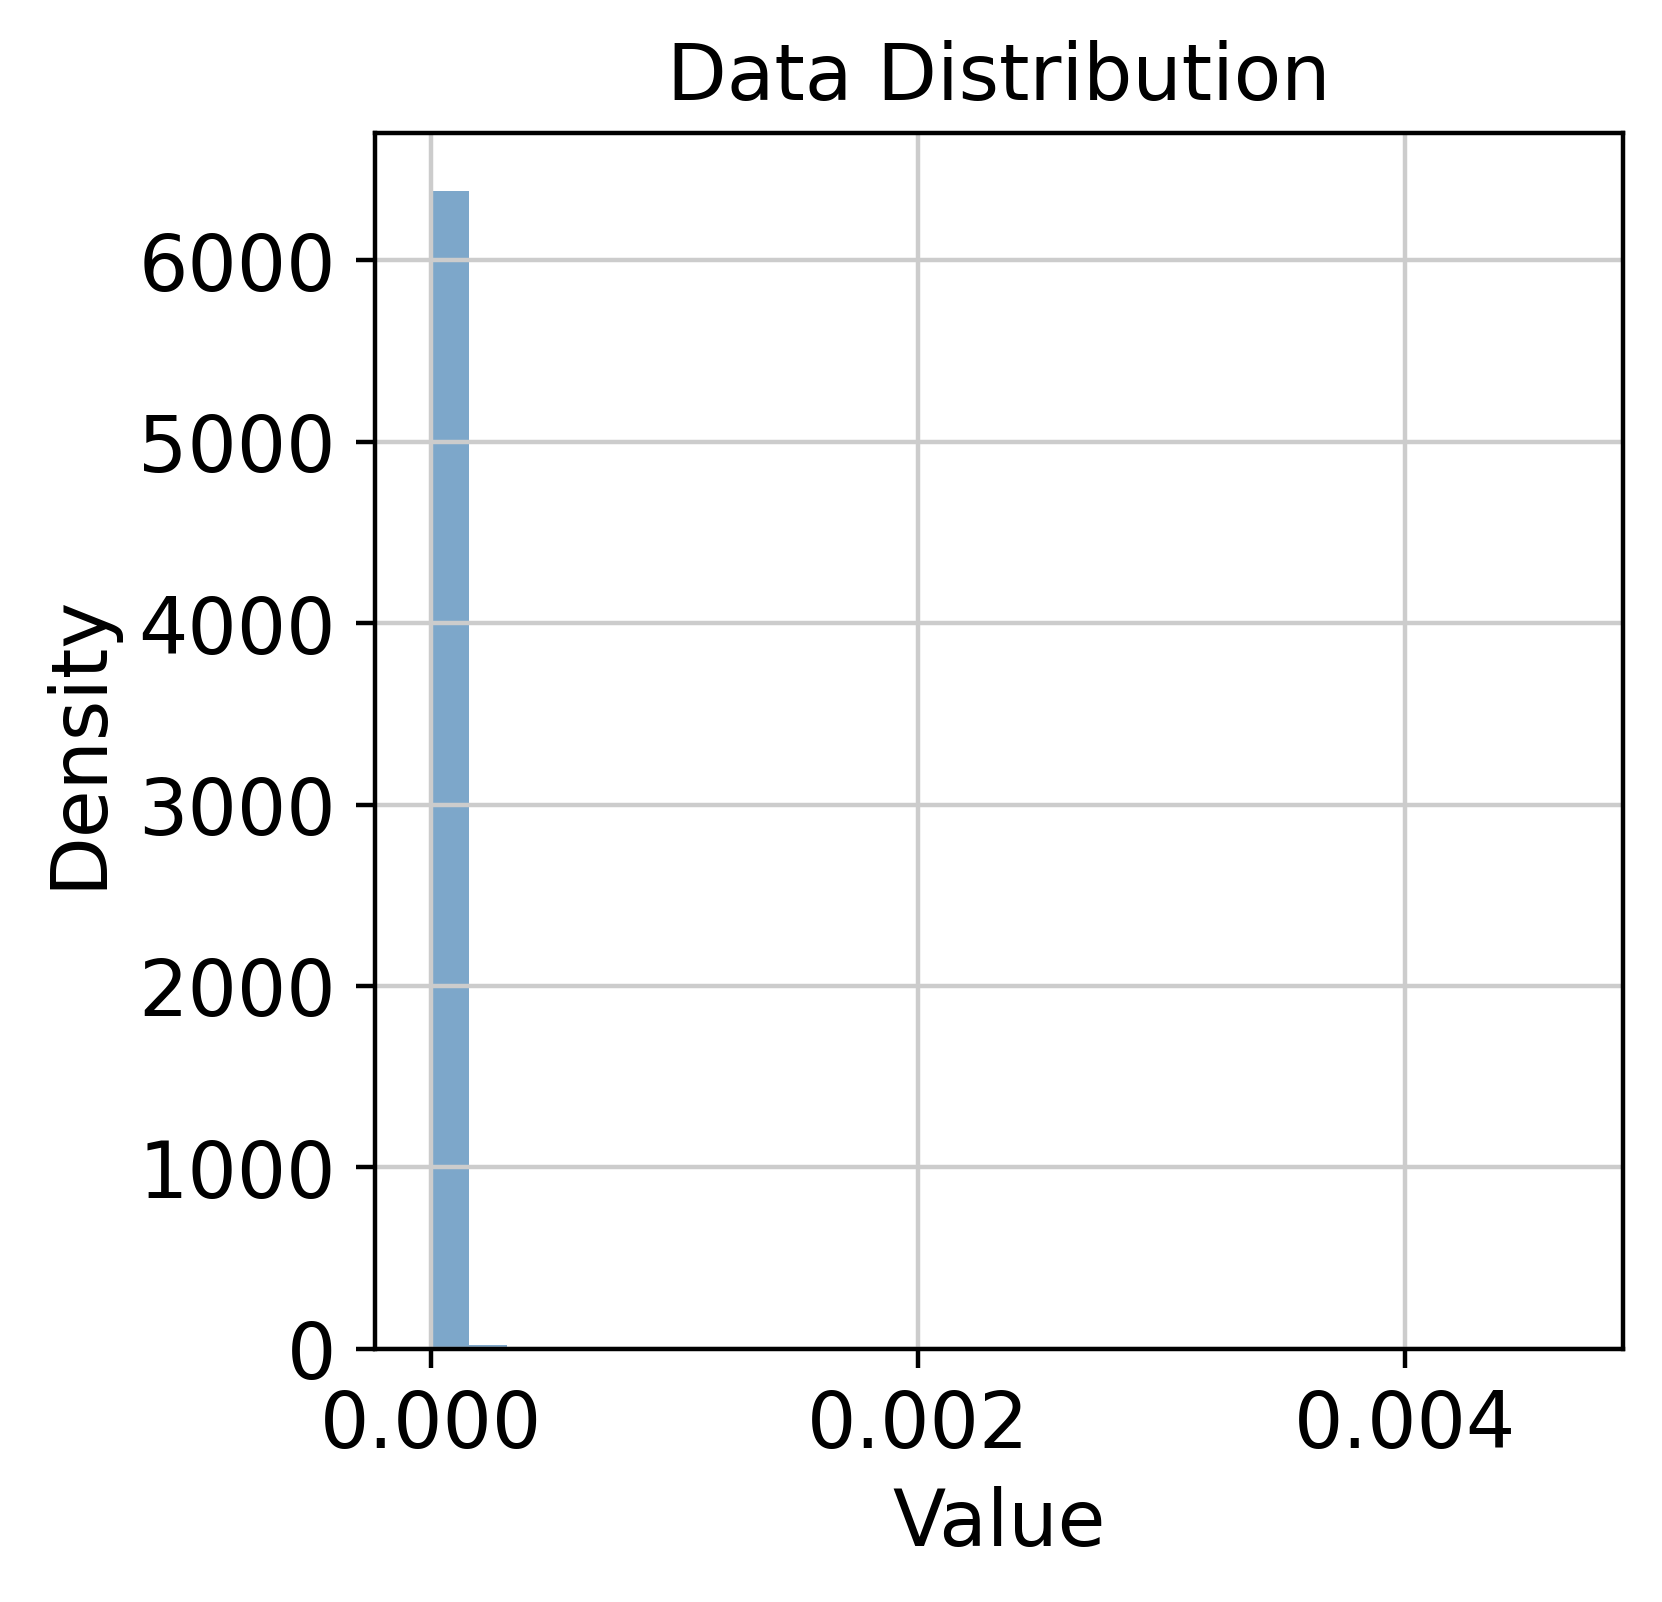

In [21]:
import matplotlib.pyplot as plt

# 绘制数据分布图
plt.hist(discriminator(ref_latent_tensor).detach().cpu().numpy(),
         bins=30, density=True, color='steelblue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Data Distribution')
plt.grid(True)

plt.show()

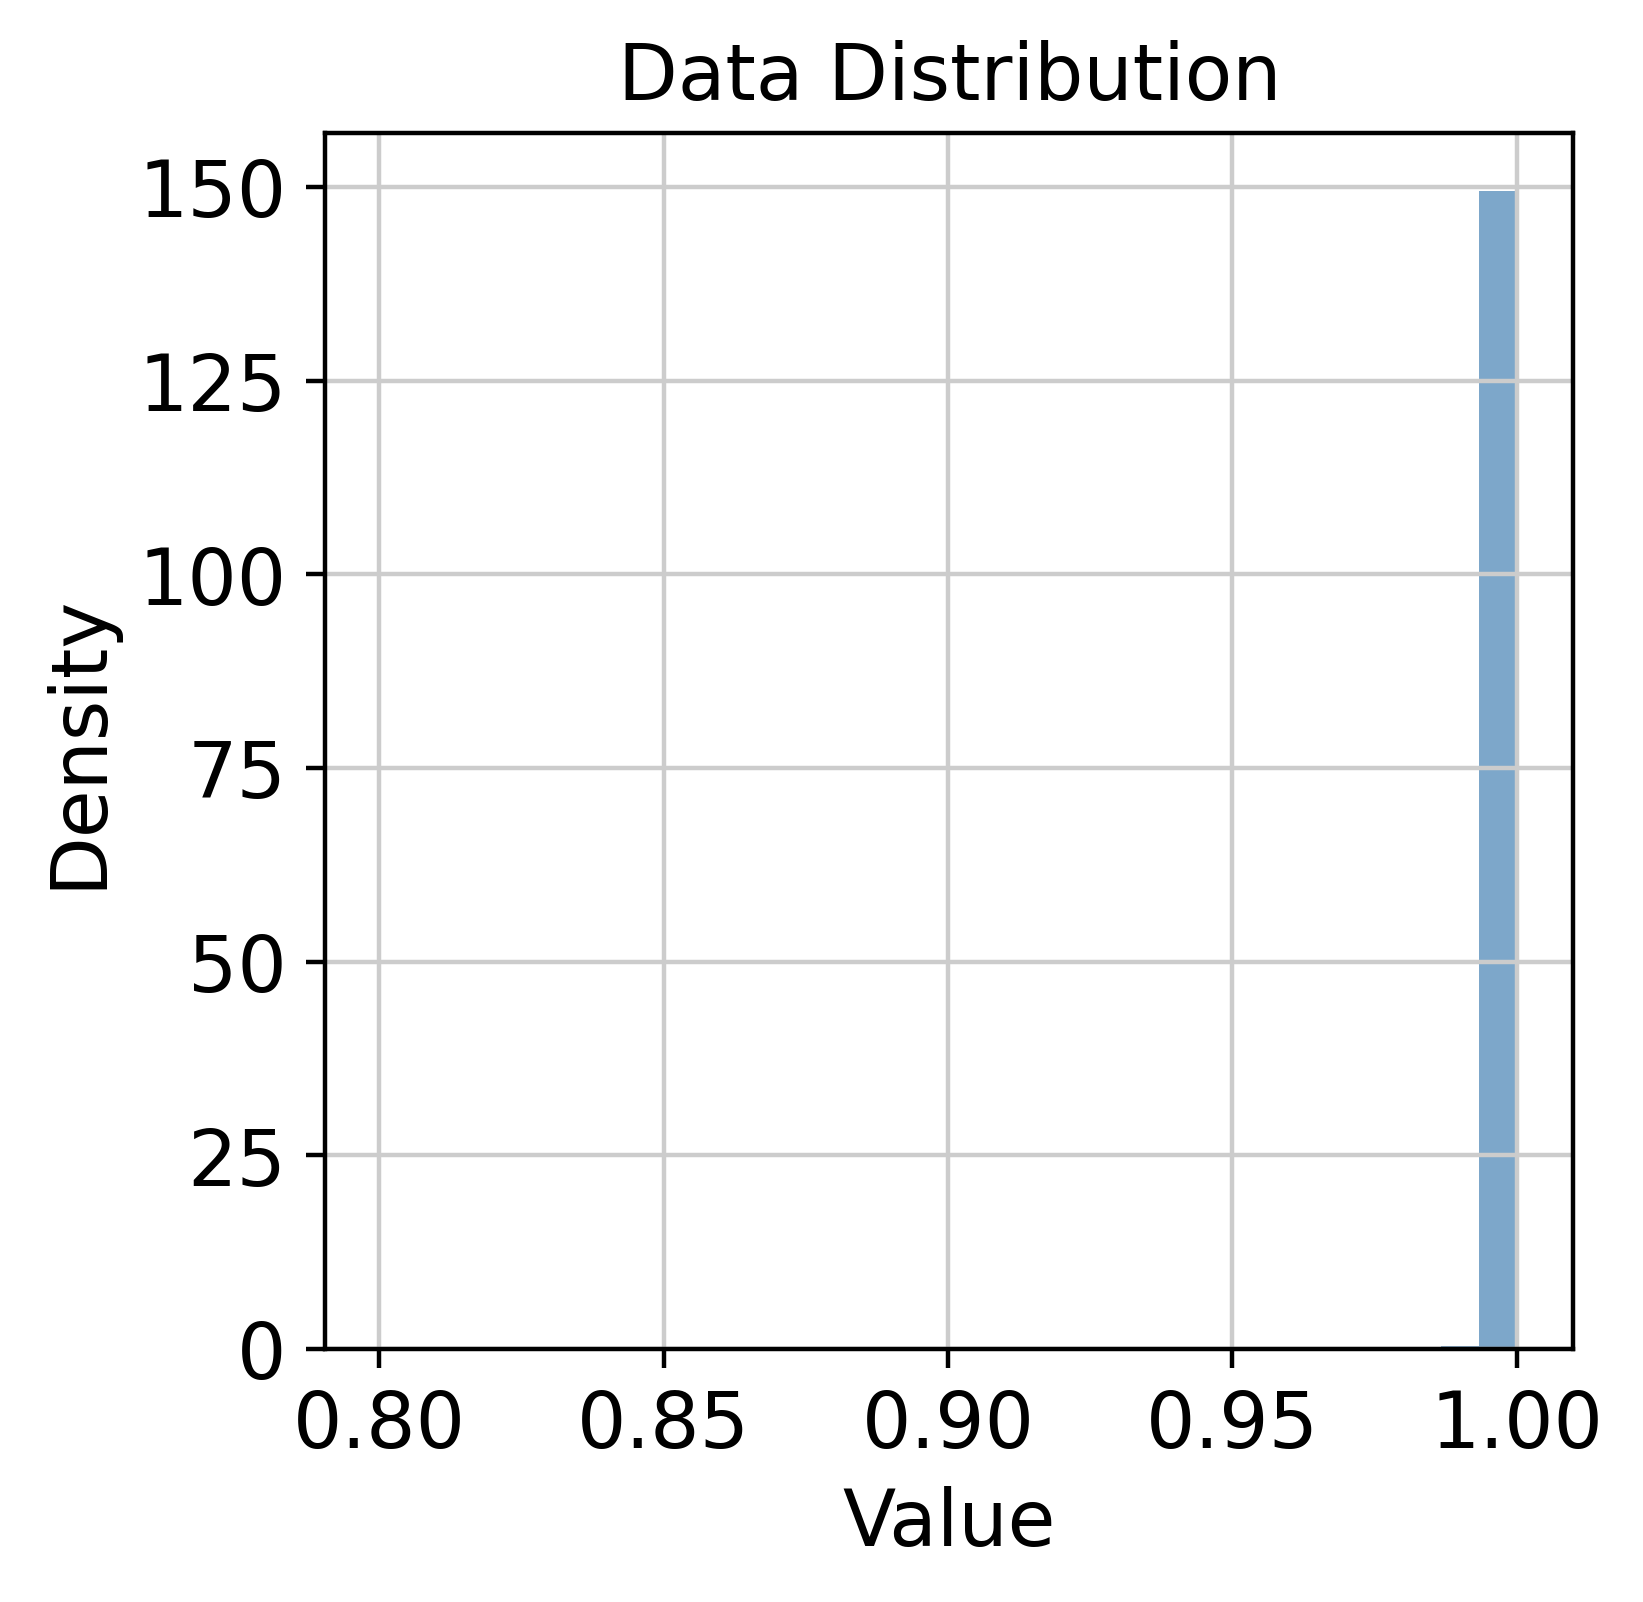

In [22]:
import matplotlib.pyplot as plt

# 绘制数据分布图
plt.hist(discriminator(z_record[19]).detach().cpu().numpy(),
         bins=30, density=True, color='steelblue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Data Distribution')
plt.grid(True)

plt.show()

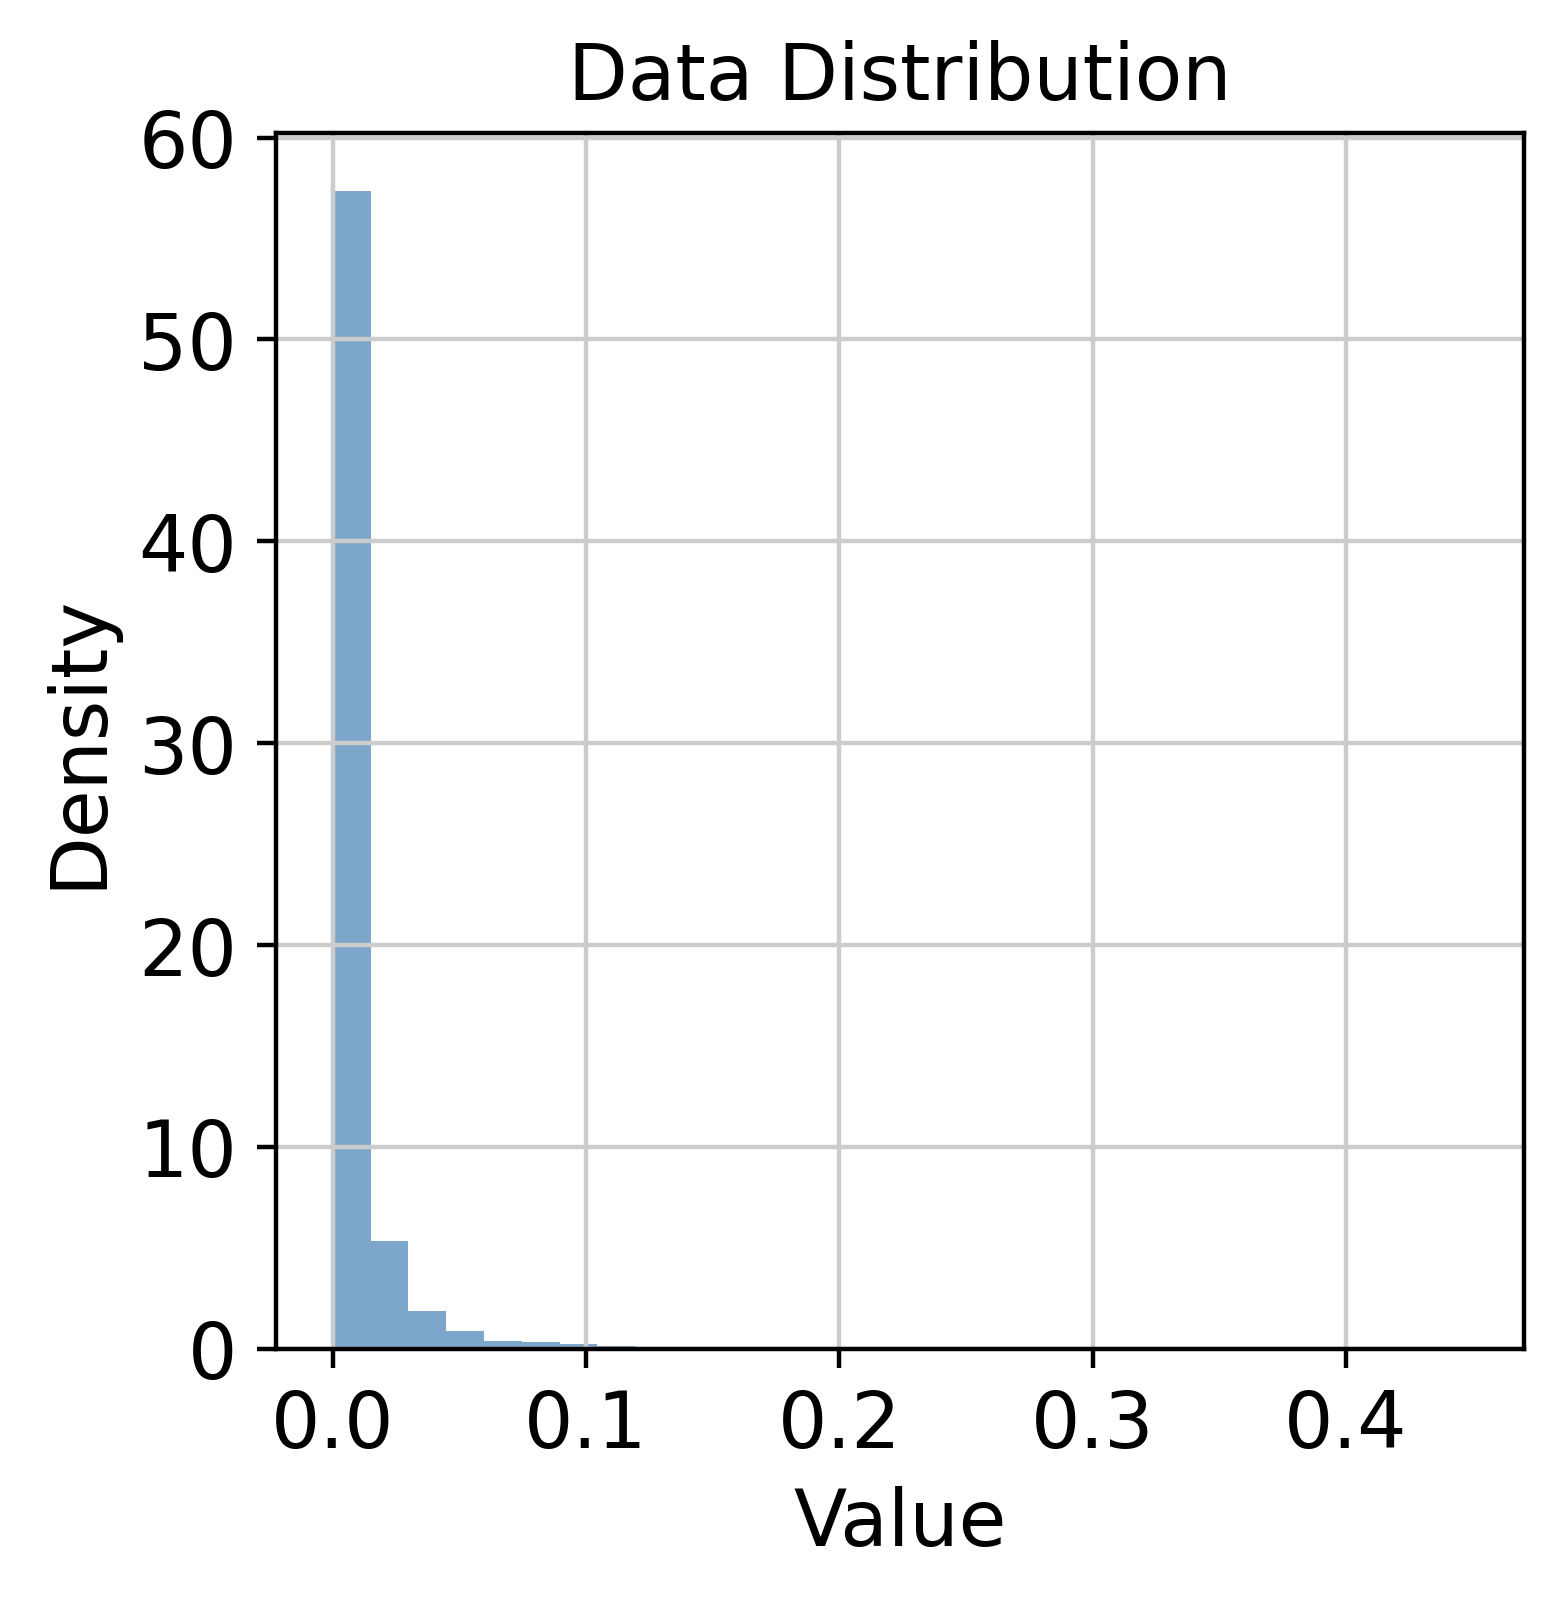

In [23]:
import matplotlib.pyplot as plt

# 绘制数据分布图
plt.hist(discriminator(z_record[0]).detach().cpu().numpy(),
         bins=30, density=True, color='steelblue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Data Distribution')
plt.grid(True)

plt.show()

In [30]:
ref_latent.X

array([[-8.93e-01,  3.94e-01, -2.12e-01, -1.29e-02, -1.30e+00, -7.58e-03,
        -1.49e+00, ...,  5.59e-01, -3.77e-01,  1.33e+00,  6.59e-01,
         1.73e-01,  2.13e+00,  8.19e-01],
       [-5.58e-01,  1.02e+00, -9.85e-01, -8.36e-01,  4.62e-01, -1.32e-02,
         1.09e+00, ...,  7.37e-01,  6.99e-02,  6.39e-01,  9.17e-01,
        -1.07e+00, -3.05e-01, -1.76e+00],
       [-1.51e+00,  2.69e-01,  3.24e-01, -3.86e-01,  7.86e-01,  4.06e-02,
        -2.50e+00, ..., -5.01e-01, -7.40e-01, -1.79e-01,  3.42e-01,
         3.22e-01,  3.73e-01,  1.30e+00],
       [-2.16e-01, -5.81e-01, -5.59e-01,  2.53e-01,  1.08e+00,  8.67e-03,
         3.47e-01, ..., -1.17e-01,  1.34e+00,  6.74e-01, -3.00e-01,
         1.49e+00,  2.52e-01,  1.14e+00],
       [-1.00e+00,  2.87e-02, -4.75e-01,  9.02e-01,  4.30e-01,  1.07e-02,
        -8.42e-01, ...,  1.60e+00, -2.45e-01,  1.08e+00, -1.98e+00,
         2.71e-02,  8.43e-01, -6.49e-01],
       [ 6.02e-01,  5.52e-02, -7.13e-01,  1.09e+00,  6.94e-01,  1.24e-03,
      

In [29]:
reference_latent.X

array([[  5890.55,   2726.95,  -7938.5 ,  -4964.08,   1471.87, -16385.28,
          2012.57, ...,  14013.62,   -645.39,   9521.32,  -7044.69,
         -3307.99,  -2866.66,  10899.24],
       [ -1251.22,   2917.82,  -4187.32, -15319.7 ,   -689.56,  21612.98,
         -1678.85, ...,  15699.75,   1316.55,  12243.7 ,   -976.59,
           759.6 ,   2252.57,  16417.81],
       [  6672.38,  -1295.84,  -6624.26,  -3494.81,   1754.2 , -15176.55,
          2026.58, ...,  12143.82,  -3890.56,  15044.33,   -533.27,
          -325.16,  -4270.25,   1928.64],
       [  2866.71,   -660.07,  -4218.64,  -1898.27,   2991.03, -18481.45,
          3145.89, ...,  10615.98,   3359.22,  10264.37,  -1212.96,
         -3102.91,  -1080.7 ,   4954.7 ],
       [ -7006.97,  13637.24,   2785.34, -15731.29,   5809.02,  14936.6 ,
           603.67, ...,  -5845.81,   1310.9 ,   4863.85,    430.85,
          8283.14,  -2584.27,  25599.3 ],
       [  5030.85,   6111.41,  -5976.22,   -782.48,  10268.96,  -4372.97,
      

In [28]:
reference_latent1.X

array([[ 1.89e+00,  7.92e-01, -7.55e-01, -2.73e+00, -2.09e-01,  3.85e-03,
        -9.00e-01, ..., -1.67e-01, -1.10e+00,  1.57e+00, -1.59e+00,
        -9.83e-01,  3.78e-01,  7.17e-01],
       [ 1.06e+00,  5.15e-01, -5.16e-01, -2.84e+00, -2.88e-01,  3.50e-03,
        -5.30e-01, ...,  7.63e-01, -1.10e+00,  2.39e+00, -1.07e+00,
         5.08e-01, -1.85e-01,  2.55e-02],
       [ 3.05e+00, -1.38e-01, -1.03e+00, -5.60e-01, -3.37e-01,  2.81e-03,
        -7.30e-01, ...,  2.43e+00, -8.75e-01,  9.04e-01,  6.07e-01,
        -4.37e-01, -8.08e-02,  8.32e-01],
       [-6.04e-01,  1.21e+00, -8.54e-01,  9.55e-03, -1.28e-01,  8.07e-03,
        -5.49e-01, ..., -5.04e-02,  3.37e-01,  1.34e+00, -2.79e-01,
        -9.68e-01, -1.27e-02,  7.51e-01],
       [ 1.17e+00,  2.60e+00,  1.24e-01, -1.82e+00,  2.12e+00,  2.10e-02,
        -3.86e-01, ..., -2.64e+00,  1.33e+00,  8.95e-01,  5.96e-02,
         1.81e+00, -1.70e+00,  2.94e+00],
       [ 1.18e+00,  8.58e-01, -7.64e-01, -4.99e-01,  1.32e-01, -1.64e-02,
      

In [15]:
optimizerD.param_groups[0]['lr']

0.00010000000000000003

In [16]:
# import os
model_path = './model'
# os.makedirs(model_path, exist_ok=True)
torch.save(discriminator.state_dict(), model_path + "/test_discrim2.pth")
torch.save(mapping_module.state_dict(), model_path + "/test_mapping2.pth")

In [17]:
save_path = './saves'
# os.makedirs(save_path, exist_ok=True)

reference_latent1 = sc.AnnData(scvi_model.get_latent_representation())
reference_latent1.obs["cell_type"] = query_adata.obs["level1"].tolist()
reference_latent1.obs["batch"] = query_adata.obs["batch"].tolist()
reference_latent1.write(save_path + "/latent_origin2.h5ad")

z_mean = torch.tensor(scvi_model.get_latent_representation()).to(device)
z_mean_transferred = mapping_module(z_mean)
reference_latent = sc.AnnData(z_mean_transferred.detach().cpu().numpy())
reference_latent.obs["cell_type"] = query_adata.obs["level1"].tolist()
reference_latent.obs["batch"] = query_adata.obs["batch"].tolist()
reference_latent.write(save_path + "/latent_transferred2.h5ad")

/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
/home/wyh/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [ ]:
import scanpy as sc
save_path = './saves'
query_latent_origin = sc.read_h5ad(save_path + "/latent_origin2.h5ad")
query_latent_transferred = sc.read_h5ad(save_path + "/latent_transferred2.h5ad")

In [ ]:
ref_latent = sc.read_h5ad("./reference_latent.h5ad")
sc.pp.subsample(ref_latent, n_obs = 10000)
merged_adata = sc.AnnData.concatenate(ref_latent, query_latent_transferred,
                                      batch_key="ref_query")
merged_adata

In [ ]:
sc.pp.neighbors(merged_adata, n_neighbors=4)
sc.tl.umap(merged_adata)
sc.pl.umap(merged_adata,
           color=['cell_type', "ref_query"],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
merged_adata0 = sc.AnnData.concatenate(ref_latent, query_latent_origin,
                                      batch_key = "ref_query")

sc.pp.neighbors(merged_adata0, n_neighbors=4)
sc.tl.umap(merged_adata0)
sc.pl.umap(merged_adata0,
           color=['cell_type', "ref_query"],
           frameon=False,
           wspace=0.6,
           )